# WebAssembly as an Enabler for Next Generation Serverless Computing

# Abstract

WebAssembly is a new binary instruction format and runtime environment capable of executing both client side and server side workloads. With its numerous advantages, including drastically reduced cold start times, efficiency, easy portability, and compatibility with the most popular programming languages today, it has the potential to revolutionize serverless computing. We evaluate the impact of WebAssembly in terms of serverless computing, building on top of existing research related to WebAssembmly in cloud and edge environments. To this end, we introduce a novel benchmarking suite comprised of 13 different functions, compatible with WebAssembly, and focusing on both microbenchmarking and real-world workloads. We also discuss possibilities of integrating WebAssembly runtimes with the application programming interfaces and command line interfaces of popular container runtimes, representing an initial step towards potential reuse of existing orchestration engines in the future, thus solving the open issue of WebAssembly workload scheduling. We evaluate the performance of such an integration by comparing the cold start delays and total execution times of three WebAssembly runtimes: WasmEdge, Wasmer, and Wasmtime to the performance of the containerd container runtime, using distroless and distro-oriented container images. Results show that WebAssembly runtimes show better results in 10 out of 13 tests, with Wasmtime being the fastest WebAssembly runtime among those evaluated. Container runtimes still offer better compute performance for complex workloads requiring larger execution times, in cases where cold start times are negligible compared to the total execution time.

# Results Analysis

In [1]:
import pandas as pd
import glob
import re
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import itertools

Defining constants which are to be used later in the analysis.

In [2]:
WASM_RUNTIMES = ['wasmedge', 'wasmtime', 'wasmer']
CONTAINER_IMAGES = ['distroless', 'debian']
COMPILATION_STRATEGIES = ['aot', 'jit']
TESTS = ['aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression']

Creating a new DataFrame which will contain all results.

In [3]:
df_results = pd.DataFrame()

Reading test data from WebAssembly runtimes.

In [4]:
for runtime in WASM_RUNTIMES:
    for compile_strategy in COMPILATION_STRATEGIES:
        result_files = glob.glob(f'results/{runtime}/{compile_strategy}/*.txt')
        for result_file in result_files:
            test_name = re.findall(r'\d+-(.*)\.txt', result_file)[0]
            df_tmp = pd.read_csv(result_file, names=['execution_time'])
            df_tmp['runtime'] = runtime
            df_tmp['compilation_strategy'] = compile_strategy
            df_tmp['test'] = test_name
            df_results = df_results.append(df_tmp)

Reading test data from distroless and debian execution strategies.

In [5]:
for container_image in CONTAINER_IMAGES:
    result_files = glob.glob(f'results/{container_image}/*.txt')
    for result_file in result_files:
        test_name = re.findall(r'\d+-(.*)\.txt', result_file)[0]
        df_tmp = pd.read_csv(result_file, names=['execution_time'])
        df_tmp['runtime'] = container_image
        df_tmp['compilation_strategy'] = 'aot'
        df_tmp['test'] = test_name
        df_results = df_results.append(df_tmp)

In [6]:
df_results.reset_index(drop=True, inplace=True)
df_results

,execution_time,runtime,compilation_strategy,test
0,0.76,wasmedge,aot,prime-numbers
1,0.80,wasmedge,aot,prime-numbers
2,0.83,wasmedge,aot,prime-numbers
3,0.74,wasmedge,aot,prime-numbers
4,0.72,wasmedge,aot,prime-numbers
...,...,...,...,...
8995,4.59,debian,aot,imageprocessing
8996,4.39,debian,aot,imageprocessing
8997,4.46,debian,aot,imageprocessing
8998,4.40,debian,aot,imageprocessing


Average execution time by runtime and compilation strategy for each test

In [7]:
df_results.groupby(['runtime', 'compilation_strategy', 'test']).mean()

execution_time
runtime  compilation_strategy test                           
debian   aot                  aes                      4.1197
                              audio-sine-wave          3.5241
                              checksum                 4.8078
                              diskio                   3.7154
                              float-operation          3.5300
...                                                       ...
wasmtime jit                  matmul                   6.9273
                              n-body                   0.8373
                              prime-numbers            0.8021
                              whatlang                 0.8547
                              zip-compression          3.2597

[90 rows x 1 columns]

# 1. WasmEdge Results Analysis

## 1.1. AOT vs. JIT Comparison

In [8]:
wasmedge_aot_mean = df_results[(df_results.runtime=='wasmedge') & (df_results.compilation_strategy=='aot')].groupby(['test']).mean()
wasmedge_aot_mean = wasmedge_aot_mean.rename({'execution_time': 'execution_time_aot'}, axis='columns')

wasmedge_jit_mean = df_results[(df_results.runtime=='wasmedge') & (df_results.compilation_strategy=='jit')].groupby(['test']).mean()
wasmedge_jit_mean = wasmedge_jit_mean.rename({'execution_time': 'execution_time_interpretation'}, axis='columns')

wasmedge_mean = pd.concat([wasmedge_aot_mean, wasmedge_jit_mean], axis='columns')
wasmedge_mean['interpretation times slower'] = round(wasmedge_mean['execution_time_interpretation']/wasmedge_mean['execution_time_aot'], 2)
# wasmedge_mean['aot times faster'] = round(wasmedge_mean['execution_time_aot']/wasmedge_mean['execution_time_interpretation'], 4)
wasmedge_mean

,execution_time_aot,execution_time_interpretation,interpretation times slower
test,,,
aes,0.8178,3.1143,3.81
audio-sine-wave,0.8011,0.9675,1.21
checksum,2.8217,420.7572,149.11
diskio,0.9131,13.2456,14.51
float-operation,0.8006,0.6979,0.87
fuzzysearch,0.8162,3.3380,4.09
imageprocessing,5.5801,957.1059,171.52
linear-equations,0.9700,31.2551,32.22
matmul,3.6132,709.4923,196.36


## 1.2. Heatmap Execution Time AOT vs. JIT

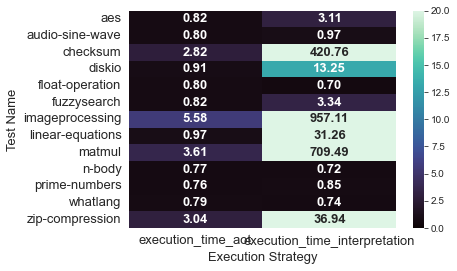

In [9]:
wasmedge_mean_heatmap = sns.heatmap(data=wasmedge_mean[['execution_time_aot', 'execution_time_interpretation']], annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako', vmin=0, vmax=20, fmt='.2f')
wasmedge_mean_heatmap.set_xlabel('Execution Strategy', fontsize=13)
wasmedge_mean_heatmap.set_ylabel('Test Name', fontsize=13)
wasmedge_mean_heatmap.tick_params(labelsize=13)
plt.show()

## 1.3. Image Size Comparison AOT vs. JIT

In [10]:
wasmedge_image_sizes = {'test': ['aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression', 'aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression'], 'execution_strategy': ['aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation','interpretation'], 'image_size': [450.27, 608.40, 430.74, 355.17, 401.50, 674.27, 896.29,705.54, 587.08, 620.47, 581.30, 713.13, 678.20, 234.64, 535.66, 217.88, 180.27, 201.01, 568.81, 418.92, 340.70, 292.28, 544.60, 525.60, 609.45, 575.17]}
#
wasmedge_image_sizes = pd.DataFrame(wasmedge_image_sizes)
wasmedge_image_sizes = wasmedge_image_sizes.reindex([1,14,5,18,9,22,10,23,11,24,12,25,0,13,2,15,3,16,4,17,6,19,7,20,8,21])
wasmedge_image_sizes

,test,execution_strategy,image_size
1,audio-sine-wave,aot,608.40
14,audio-sine-wave,interpretation,535.66
5,fuzzysearch,aot,674.27
18,fuzzysearch,interpretation,568.81
9,n-body,aot,620.47
22,n-body,interpretation,544.60
10,prime-numbers,aot,581.30
23,prime-numbers,interpretation,525.60
11,whatlang,aot,713.13
24,whatlang,interpretation,609.45


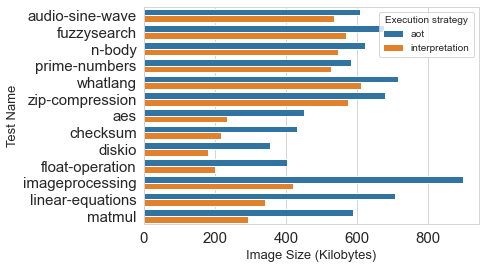

In [11]:
wasmedge_image_sizes_barplot = sns.barplot(data = wasmedge_image_sizes, y='test', x='image_size', hue='execution_strategy')
wasmedge_image_sizes_barplot.set_xlabel('Image Size (Kilobytes)', fontsize=13)
wasmedge_image_sizes_barplot.set_ylabel('Test Name', fontsize=13)
wasmedge_image_sizes_barplot.tick_params(labelsize=15)
wasmedge_image_sizes_barplot.legend(title='Execution strategy')
fig = wasmedge_image_sizes_barplot.get_figure()
fig.savefig('figures/01-wasmedge-02-wasmedge_image_sizes_barplot', bbox_inches='tight', dpi=300)

## 1.4. Statistically Significant Differences in Mean Execution Times

In [12]:
for test in TESTS:
    tmp_wasmedge_execution_time_aot = df_results[(df_results.runtime=='wasmedge') & (df_results.compilation_strategy=='aot') & (df_results.test == test)]['execution_time']
    tmp_wasmedge_execution_time_jit = df_results[(df_results.runtime=='wasmedge') & (df_results.compilation_strategy=='jit') & (df_results.test == test)]['execution_time']
    alpha = 0.05
    statistic, pvalue = stats.kruskal(tmp_wasmedge_execution_time_aot, tmp_wasmedge_execution_time_jit)
    if pvalue > alpha:
        print(f'[{test}] Fail to reject H0 - same distribution (p={pvalue})')
    else:
        print(f'[{test}] Reject H0 - different distribution (p={pvalue})')

[aes] Reject H0 - different distribution (p=2.087289336332445e-34)
[audio-sine-wave] Reject H0 - different distribution (p=1.40608969045312e-33)
[checksum] Reject H0 - different distribution (p=2.339565184269017e-34)
[diskio] Reject H0 - different distribution (p=2.2517902605421734e-34)
[float-operation] Reject H0 - different distribution (p=1.8850167683752933e-33)
[fuzzysearch] Reject H0 - different distribution (p=2.0900095452066468e-34)
[imageprocessing] Reject H0 - different distribution (p=2.403536067251292e-34)
[linear-equations] Reject H0 - different distribution (p=2.208926072450691e-34)
[matmul] Reject H0 - different distribution (p=2.5036839340192494e-34)
[n-body] Reject H0 - different distribution (p=5.299466870942772e-18)
[prime-numbers] Reject H0 - different distribution (p=2.5627940063418752e-30)
[whatlang] Reject H0 - different distribution (p=4.291323079482615e-23)
[zip-compression] Reject H0 - different distribution (p=2.4015029796440116e-34)


# 2. WasmTime Results Analysis

## 2.1. AOT vs. JIT Comparison

In [13]:
wasmtime_aot_mean = df_results[(df_results.runtime=='wasmtime') & (df_results.compilation_strategy=='aot')].groupby(['test']).mean()
wasmtime_aot_mean = wasmtime_aot_mean.rename({'execution_time': 'execution_time_aot'}, axis='columns')

wasmtime_jit_mean = df_results[(df_results.runtime=='wasmtime') & (df_results.compilation_strategy=='jit')].groupby(['test']).mean()
wasmtime_jit_mean = wasmtime_jit_mean.rename({'execution_time': 'execution_time_jit'}, axis='columns')

wasmtime_mean = pd.concat([wasmtime_aot_mean, wasmtime_jit_mean], axis='columns')
wasmtime_mean['jit times slower'] = round(wasmtime_mean['execution_time_jit']/wasmtime_mean['execution_time_aot'], 2)
wasmtime_mean

,execution_time_aot,execution_time_jit,jit times slower
test,,,
aes,0.7370,1.2215,1.66
audio-sine-wave,0.6232,0.8178,1.31
checksum,3.6143,4.1259,1.14
diskio,0.8756,1.3369,1.53
float-operation,0.7048,1.1013,1.56
fuzzysearch,0.7046,0.8600,1.22
imageprocessing,8.6605,9.8001,1.13
linear-equations,0.9241,1.5558,1.68
matmul,6.3049,6.9273,1.10


## 2.2. Heatmap Execution Time AOT vs. JIT

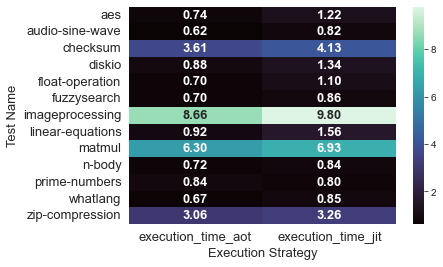

In [14]:
wasmtime_mean_heatmap = sns.heatmap(data=wasmtime_mean[['execution_time_aot', 'execution_time_jit']], annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako', fmt='.2f')
wasmtime_mean_heatmap.set_xlabel('Execution Strategy', fontsize=13)
wasmtime_mean_heatmap.set_ylabel('Test Name', fontsize=13)
wasmtime_mean_heatmap.tick_params(labelsize=13)
plt.show()

## 2.3. Image Size Comparison AOT vs. JIT

In [15]:
wasmtime_image_sizes = {'test': ['aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression', 'aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression'], 'execution_strategy': ['aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit'], 'image_size': [646.83, 200.56, 613.77, 509.44, 567.16, 331.74, 1320, 1060, 891.87, 214.16, 159.79, 374.52, 314.51, 234.64, 535.66, 217.89, 180.27, 201.01, 568.81, 418.92, 340.70, 292.28, 544.60, 525.60, 609.45, 575.17]}

wasmtime_image_sizes = pd.DataFrame(wasmtime_image_sizes)
wasmtime_image_sizes = wasmtime_image_sizes.reindex([1,14,5,18,9,22,10,23,11,24,12,25,0,13,2,15,3,16,4,17,6,19,7,20,8,21])
wasmtime_image_sizes

,test,execution_strategy,image_size
1,audio-sine-wave,aot,200.56
14,audio-sine-wave,jit,535.66
5,fuzzysearch,aot,331.74
18,fuzzysearch,jit,568.81
9,n-body,aot,214.16
22,n-body,jit,544.60
10,prime-numbers,aot,159.79
23,prime-numbers,jit,525.60
11,whatlang,aot,374.52
24,whatlang,jit,609.45


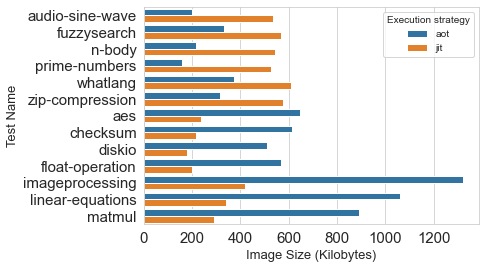

In [16]:
wasmtime_image_sizes_barplot = sns.barplot(data = wasmtime_image_sizes, y='test', x='image_size', hue='execution_strategy')
wasmtime_image_sizes_barplot.set_xlabel('Image Size (Kilobytes)', fontsize=13)
wasmtime_image_sizes_barplot.set_ylabel('Test Name', fontsize=13)
wasmtime_image_sizes_barplot.tick_params(labelsize=15)
wasmtime_image_sizes_barplot.legend(title='Execution strategy')
fig = wasmtime_image_sizes_barplot.get_figure()
fig.savefig('figures/02-wasmtime-02-wasmedge_image_sizes_barplot', bbox_inches='tight', dpi=300)

## 2.4. Statistically Significant Differences in Mean Execution Times

In [17]:
for test in TESTS:
    tmp_wasmtime_execution_time_aot = df_results[(df_results.runtime=='wasmtime') & (df_results.compilation_strategy=='aot') & (df_results.test == test)]['execution_time']
    tmp_wasmtime_execution_time_jit = df_results[(df_results.runtime=='wasmtime') & (df_results.compilation_strategy=='jit') & (df_results.test == test)]['execution_time']
    alpha = 0.05
    statistic, pvalue = stats.kruskal(tmp_wasmtime_execution_time_aot, tmp_wasmtime_execution_time_jit)
    if pvalue > alpha:
        print(f'[{test}] Fail to reject H0 - same distribution (p={pvalue})')
    else:
        print(f'[{test}] Reject H0 - different distribution (p={pvalue})')

[aes] Reject H0 - different distribution (p=1.9817120499960647e-34)
[audio-sine-wave] Reject H0 - different distribution (p=2.019248626802384e-34)
[checksum] Reject H0 - different distribution (p=2.25166300993562e-34)
[diskio] Reject H0 - different distribution (p=2.229249586223941e-34)
[float-operation] Reject H0 - different distribution (p=2.0448110705427843e-34)
[fuzzysearch] Reject H0 - different distribution (p=2.2052541078219495e-34)
[imageprocessing] Reject H0 - different distribution (p=2.3006557268801964e-34)
[linear-equations] Reject H0 - different distribution (p=2.1564617435131783e-34)
[matmul] Reject H0 - different distribution (p=2.3127650483597184e-15)
[n-body] Reject H0 - different distribution (p=3.3872517210775735e-08)
[prime-numbers] Reject H0 - different distribution (p=7.366281182450618e-12)
[whatlang] Reject H0 - different distribution (p=3.1965351191745007e-34)
[zip-compression] Reject H0 - different distribution (p=3.8891674898061075e-34)


# 3. Wasmer Results Analysis

## 3.1. AOT vs. JIT Comparison

In [18]:
wasmer_aot_mean = df_results[(df_results.runtime=='wasmer') & (df_results.compilation_strategy=='aot')].groupby(['test']).mean()
wasmer_aot_mean = wasmer_aot_mean.rename({'execution_time': 'execution_time_aot'}, axis='columns')

wasmer_jit_mean = df_results[(df_results.runtime=='wasmer') & (df_results.compilation_strategy=='jit')].groupby(['test']).mean()
wasmer_jit_mean = wasmer_jit_mean.rename({'execution_time': 'execution_time_jit'}, axis='columns')

wasmer_mean = pd.concat([wasmer_aot_mean, wasmer_jit_mean], axis='columns')
wasmer_mean['jit times slower'] = round(wasmer_mean['execution_time_jit']/wasmer_mean['execution_time_aot'], 2)
wasmer_mean

,execution_time_aot,execution_time_jit,jit times slower
test,,,
float-operation,0.7508,1.2034,1.60
linear-equations,1.0072,1.6638,1.65
matmul,6.5564,7.0870,1.08
n-body,0.7248,0.8320,1.15
prime-numbers,0.7017,0.8298,1.18
whatlang,0.7346,0.8404,1.14


## 3.2. Heatmap Execution Time AOT vs. JIT

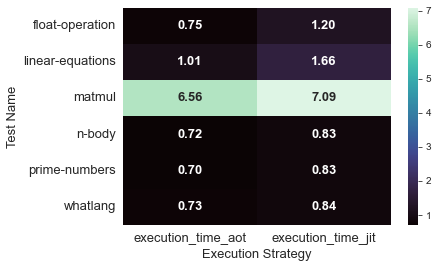

In [19]:
wasmer_mean_heatmap = sns.heatmap(data=wasmer_mean[['execution_time_aot', 'execution_time_jit']], annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako', fmt='.2f')
wasmer_mean_heatmap.set_xlabel('Execution Strategy', fontsize=13)
wasmer_mean_heatmap.set_ylabel('Test Name', fontsize=13)
wasmer_mean_heatmap.tick_params(labelsize=13)
plt.show()

## 3.3. - Image Size Comparison AOT vs. JIT

In [20]:
wasmer_image_sizes = {'test': ['aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression', 'aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression'], 'execution_strategy': ['aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','aot','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit','jit'], 'image_size': [897.86, 694.69, 873.36, 719.82, 817.80, 826.61, 1860, 1490, 1220, 722.02, 653.00, 864.29, 826.91, 234.64, 535.66, 217.89, 180.27, 201.01, 568.81, 418.92, 340.70, 292.28, 544.60, 525.60, 609.45, 575.17]}
wasmer_image_sizes = pd.DataFrame(wasmer_image_sizes)
wasmer_image_sizes = wasmer_image_sizes.reindex([1,14,5,18,9,22,10,23,11,24,12,25,0,13,2,15,3,16,4,17,6,19,7,20,8,21])
wasmer_image_sizes

,test,execution_strategy,image_size
1,audio-sine-wave,aot,694.69
14,audio-sine-wave,jit,535.66
5,fuzzysearch,aot,826.61
18,fuzzysearch,jit,568.81
9,n-body,aot,722.02
22,n-body,jit,544.60
10,prime-numbers,aot,653.00
23,prime-numbers,jit,525.60
11,whatlang,aot,864.29
24,whatlang,jit,609.45


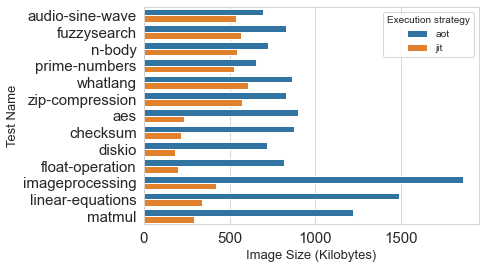

In [21]:
wasmer_image_sizes_barplot = sns.barplot(data = wasmer_image_sizes, y='test', x='image_size', hue='execution_strategy')
wasmer_image_sizes_barplot.set_xlabel('Image Size (Kilobytes)', fontsize=13)
wasmer_image_sizes_barplot.set_ylabel('Test Name', fontsize=13)
wasmer_image_sizes_barplot.tick_params(labelsize=15)
wasmer_image_sizes_barplot.legend(title='Execution strategy')
fig = wasmer_image_sizes_barplot.get_figure()
fig.savefig('figures/03-wasmer-02-wasmedge_image_sizes_barplot', bbox_inches='tight', dpi=300)

## 3.4. Statistically Significant Differences in Mean Execution Times

In [22]:
for test in ['float-operation','linear-equations','matmul','n-body','prime-numbers','whatlang']:
    tmp_wasmer_execution_time_aot = df_results[(df_results.runtime=='wasmer') & (df_results.compilation_strategy=='aot') & (df_results.test == test)]['execution_time']
    tmp_wasmer_execution_time_jit = df_results[(df_results.runtime=='wasmer') & (df_results.compilation_strategy=='jit') & (df_results.test == test)]['execution_time']
    alpha = 0.05
    statistic, pvalue = stats.kruskal(tmp_wasmer_execution_time_aot, tmp_wasmer_execution_time_jit)
    if pvalue > alpha:
        print(f'[{test}] Fail to reject H0 - same distribution (p={pvalue})')
    else:
        print(f'[{test}] Reject H0 - different distribution (p={pvalue})')

[float-operation] Reject H0 - different distribution (p=2.110820118925862e-34)
[linear-equations] Reject H0 - different distribution (p=2.135575708042919e-34)
[matmul] Reject H0 - different distribution (p=5.693616550511382e-12)
[n-body] Reject H0 - different distribution (p=2.040929493898963e-33)
[prime-numbers] Reject H0 - different distribution (p=3.969447653125526e-34)
[whatlang] Reject H0 - different distribution (p=3.111373809040627e-32)


# 4. Distroelss and Debian Results Analysis

## 4.1. Distroless vs. Debian Comparison

In [23]:
distroless_mean = df_results[(df_results.runtime=='distroless')].groupby(['test']).mean()
distroless_mean = distroless_mean.rename({'execution_time': 'execution_time_distroless'}, axis='columns')

debian_mean = df_results[(df_results.runtime=='debian')].groupby(['test']).mean()
debian_mean = debian_mean.rename({'execution_time': 'execution_time_debian'}, axis='columns')

distroless_debian_mean = pd.concat([distroless_mean, debian_mean], axis='columns')
distroless_debian_mean['debian times slower'] = round(distroless_debian_mean['execution_time_debian']/distroless_debian_mean['execution_time_distroless'], 2)
distroless_debian_mean

,execution_time_distroless,execution_time_debian,debian times slower
test,,,
aes,1.8785,4.1197,2.19
audio-sine-wave,1.5910,3.5241,2.22
checksum,2.7728,4.8078,1.73
diskio,1.6408,3.7154,2.26
float-operation,1.5234,3.5300,2.32
fuzzysearch,1.4540,3.5214,2.42
imageprocessing,2.4391,4.5162,1.85
linear-equations,1.5887,3.5529,2.24
matmul,2.6960,4.7505,1.76


## 4.2. Heatmap Execution Time Distroless vs. Debian

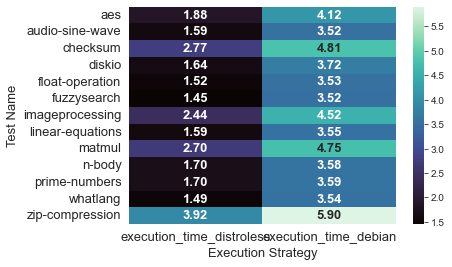

In [24]:
distroless_debian_mean_heatmap = sns.heatmap(data=distroless_debian_mean[['execution_time_distroless', 'execution_time_debian']], annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako', fmt='.2f')
distroless_debian_mean_heatmap.set_xlabel('Execution Strategy', fontsize=13)
distroless_debian_mean_heatmap.set_ylabel('Test Name', fontsize=13)
distroless_debian_mean_heatmap.tick_params(labelsize=13)
plt.show()

## 4.3. Image Size Comparison Distroless vs. Debian

In [25]:
distroless_debian_image_sizes = {'test': ['aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression', 'aes', 'audio-sine-wave', 'checksum', 'diskio','float-operation','fuzzysearch','imageprocessing','linear-equations','matmul','n-body','prime-numbers','whatlang','zip-compression'], 'image_type': ['distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','distroless','debian','debian','debian','debian','debian','debian','debian','debian','debian','debian','debian','debian','debian'], 'image_size': [10710, 10480, 10680, 10590, 10650, 10600, 10980, 10900, 10760, 10490, 10480, 10580, 10540, 53690, 53460, 53660, 53570, 53630, 53580, 53960, 53870, 53740, 53470, 53460, 53560, 53520]}

distroless_debian_image_sizes = pd.DataFrame(distroless_debian_image_sizes)
distroless_debian_image_sizes = distroless_debian_image_sizes.reindex([1,14,5,18,9,22,10,23,11,24,12,25,0,13,2,15,3,16,4,17,6,19,7,20,8,21])
distroless_debian_image_sizes

,test,image_type,image_size
1,audio-sine-wave,distroless,10480
14,audio-sine-wave,debian,53460
5,fuzzysearch,distroless,10600
18,fuzzysearch,debian,53580
9,n-body,distroless,10490
22,n-body,debian,53470
10,prime-numbers,distroless,10480
23,prime-numbers,debian,53460
11,whatlang,distroless,10580
24,whatlang,debian,53560


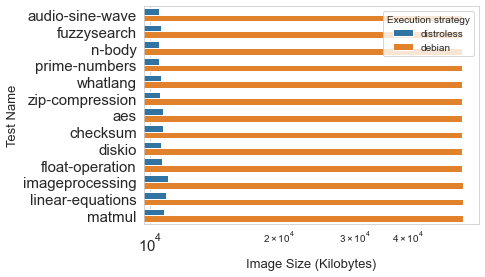

In [26]:
distroless_debian_image_sizes_barplot = sns.barplot(data = distroless_debian_image_sizes, y='test', x='image_size', hue='image_type')
distroless_debian_image_sizes_barplot.set_xlabel('Image Size (Kilobytes)', fontsize=13)
distroless_debian_image_sizes_barplot.set_ylabel('Test Name', fontsize=13)
distroless_debian_image_sizes_barplot.tick_params(labelsize=15)
distroless_debian_image_sizes_barplot.legend(title='Execution strategy')
distroless_debian_image_sizes_barplot.set(xscale="log")
fig = distroless_debian_image_sizes_barplot.get_figure()
fig.savefig('figures/04-wasmer-02-distroless-debian_image_sizes_barplot', bbox_inches='tight', dpi=300)

## 4.4. Statistically Significant Differences in Mean Execution Times

In [27]:
for test in TESTS:
    tmp_distroless_execution_time = df_results[(df_results.runtime=='distroless') & (df_results.test == test)]['execution_time']
    tmp_debian_execution_time = df_results[(df_results.runtime=='debian') & (df_results.test == test)]['execution_time']
    alpha = 0.05
    statistic, pvalue = stats.kruskal(tmp_distroless_execution_time, tmp_debian_execution_time)
    if pvalue > alpha:
        print(f'[{test}] Fail to reject H0 - same distribution (p={pvalue})')
    else:
        print(f'[{test}] Reject H0 - different distribution (p={pvalue})')

[aes] Reject H0 - different distribution (p=5.7962203375370764e-27)
[audio-sine-wave] Reject H0 - different distribution (p=2.406792493034996e-34)
[checksum] Reject H0 - different distribution (p=2.391362627284941e-34)
[diskio] Reject H0 - different distribution (p=2.4074714554682766e-34)
[float-operation] Reject H0 - different distribution (p=2.3006557268801964e-34)
[fuzzysearch] Reject H0 - different distribution (p=2.271727325391898e-34)
[imageprocessing] Reject H0 - different distribution (p=2.3618574615374824e-34)
[linear-equations] Reject H0 - different distribution (p=2.3316534036386357e-34)
[matmul] Reject H0 - different distribution (p=5.543168411664284e-20)
[n-body] Reject H0 - different distribution (p=2.381532719956663e-34)
[prime-numbers] Reject H0 - different distribution (p=2.4275164854325713e-34)
[whatlang] Reject H0 - different distribution (p=2.329021936122658e-34)
[zip-compression] Reject H0 - different distribution (p=2.395008343083866e-34)


# 5. Comparison

## 5.1. Comparison of AOT Execution Performance Across All Runtimes

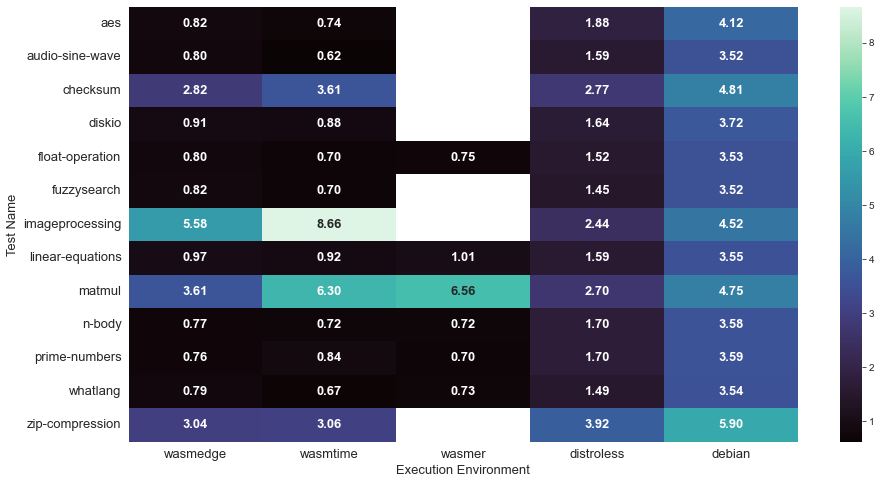

In [28]:
aot_execution_time_all = df_results[(df_results.compilation_strategy=='aot')]
aot_execution_time_all = aot_execution_time_all.groupby(['test', 'runtime']).mean().reset_index()
aot_execution_time_all = aot_execution_time_all.pivot(index='test', columns='runtime', values='execution_time')
aot_execution_time_all = aot_execution_time_all[['wasmedge', 'wasmtime', 'wasmer', 'distroless', 'debian']]
plt.figure(figsize=(15,8))
aot_execution_time_heatmap = sns.heatmap(data=aot_execution_time_all, annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako',  fmt='.2f')
aot_execution_time_heatmap.set_xlabel('Execution Environment', fontsize=13)
aot_execution_time_heatmap.set_ylabel('Test Name', fontsize=13)
aot_execution_time_heatmap.tick_params(labelsize=13)
plt.show()

## 5.2. - Comparison of JIT Execution Performance Across All Runtimes

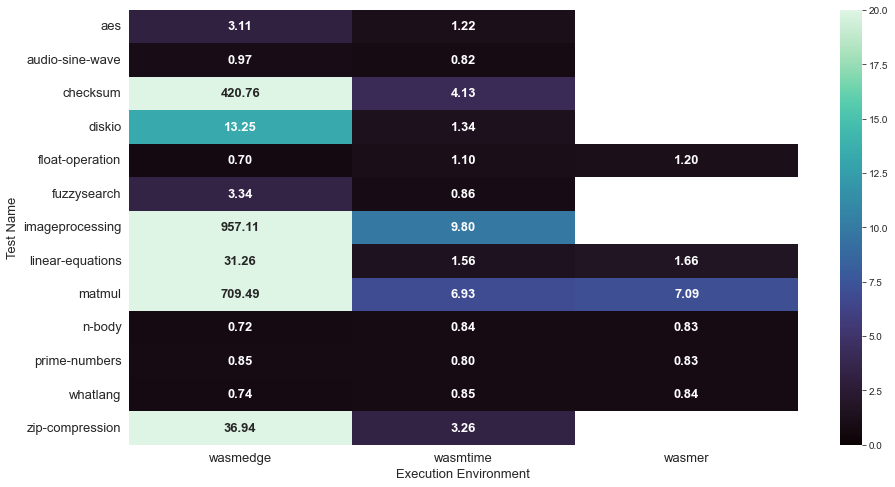

In [29]:
jit_execution_time_all = df_results[(df_results.compilation_strategy=='jit')]
jit_execution_time_all = jit_execution_time_all.groupby(['test', 'runtime']).mean().reset_index()
jit_execution_time_all = jit_execution_time_all.pivot(index='test', columns='runtime', values='execution_time')
jit_execution_time_all = jit_execution_time_all[['wasmedge', 'wasmtime', 'wasmer']]
plt.figure(figsize=(15,8))
jit_execution_time_heatmap = sns.heatmap(data=jit_execution_time_all, annot=True, annot_kws={'fontsize':13, 'weight': 'bold'}, cmap='mako',  fmt='.2f', vmin=0, vmax=20)
jit_execution_time_heatmap.set_xlabel('Execution Environment', fontsize=13)
jit_execution_time_heatmap.set_ylabel('Test Name', fontsize=13)
jit_execution_time_heatmap.tick_params(labelsize=13)
plt.show()

## 5.3. AOT Execution Performance Comparison

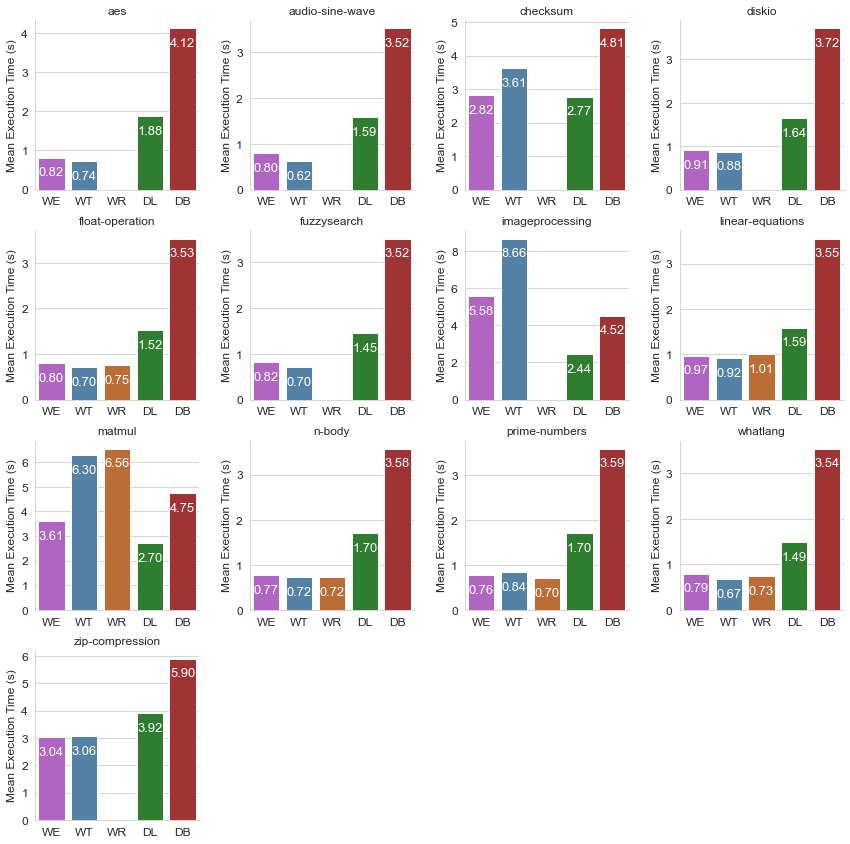

In [30]:
aot_execution_time_all = df_results[(df_results.compilation_strategy=='aot')]
aot_execution_time_all = aot_execution_time_all.groupby(['test', 'runtime']).mean().reset_index()
aot_execution_time_all = aot_execution_time_all.replace({'distroless': 'DL', 'debian': 'DB', 'wasmedge': 'WE', 'wasmtime': 'WT', 'wasmer':'WR'})
aot_execution_time_all_bar_plot = sns.FacetGrid(
    aot_execution_time_all,
    col="test", hue='runtime',col_wrap=4, sharey=False,
    palette=['firebrick', 'forestgreen', 'mediumorchid', 'steelblue', 'chocolate'],
    sharex=False)
aot_execution_time_all_bar_plot = aot_execution_time_all_bar_plot.map(sns.barplot, 'runtime',
                                                                                  'execution_time',
                                                                                  order=['WE', 'WT', 'WR', 'DL', 'DB'])
aot_execution_time_all_bar_plot.set_titles('{col_name}', size=12)
aot_execution_time_all_bar_plot.fig.tight_layout(w_pad=3)
for ax in aot_execution_time_all_bar_plot.axes.ravel():
    ax.set_ylabel('Mean Execution Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

aot_execution_time_all_bar_plot.savefig('figures/05-all-aot', bbox_inches='tight', dpi=300)
plt.show()

## 5.4. JIT Execution Performance Comparison

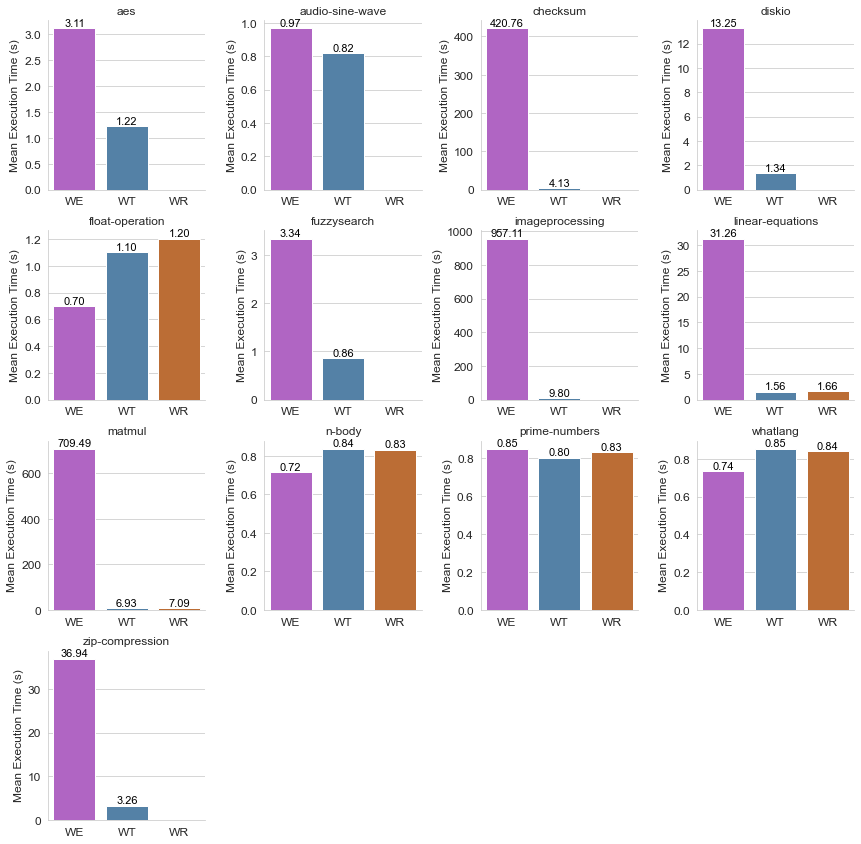

In [31]:
jit_execution_time_all = df_results[(df_results.compilation_strategy=='jit')]
jit_execution_time_all = jit_execution_time_all.groupby(['test', 'runtime']).mean().reset_index()
jit_execution_time_all = jit_execution_time_all.replace({'wasmedge': 'WE', 'wasmtime': 'WT', 'wasmer':'WR'})
jit_execution_time_all_bar_plot = sns.FacetGrid(
    jit_execution_time_all,
    col="test", hue='runtime',col_wrap=4, sharey=False,
    sharex=False,
    palette=['mediumorchid', 'steelblue', 'chocolate', 'firebrick', 'forestgreen']
)
jit_execution_time_all_bar_plot = jit_execution_time_all_bar_plot.map(sns.barplot, 'runtime',
                                                                                  'execution_time',
                                                                                  order=['WE', 'WT', 'WR'])
jit_execution_time_all_bar_plot.set_titles('{col_name}', size=12)
jit_execution_time_all_bar_plot.fig.tight_layout(w_pad=3)
for ax in jit_execution_time_all_bar_plot.axes.ravel():
    ax.set_ylabel('Mean Execution Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, 5), textcoords='offset points', fontsize=11, color='black')
jit_execution_time_all_bar_plot.savefig('figures/06-all-jit', bbox_inches='tight', dpi=300)
plt.show()

## 5.5. AOT Statistical Significance in Mean Execution Times

In [32]:
for test in TESTS:
    for runtime1, runtime2 in itertools.combinations(['wasmedge', 'wasmtime', 'wasmer', 'distroless', 'debian'], 2):
        if runtime1 == runtime2 or (
                (runtime1 == 'wasmer' or runtime2 == 'wasmer') and test not in ['float-operation', 'linear-equations',
                                                                                'matmul', 'n-body', 'prime-numbers',
                                                                                'whatlang']):
            continue
        tmp_exec_time_1 = df_results[
            (df_results.runtime == runtime1) & (df_results.compilation_strategy == 'aot') & (df_results.test == test)][
            'execution_time']
        tmp_exec_time_2 = df_results[
            (df_results.runtime == runtime2) & (df_results.compilation_strategy == 'aot') & (df_results.test == test)][
            'execution_time']
        alpha = 0.05
        statistic, pvalue = stats.kruskal(tmp_exec_time_1, tmp_exec_time_2)
        if pvalue > alpha:
            print(f'[{runtime1} vs. {runtime2}][{test}] Fail to reject H0 - same distribution (p={pvalue})')
        else:
            pass
            # print(f'[{runtime1} vs. {runtime2}][{test}] Reject H0 - different distribution (p={pvalue})')

[wasmedge vs. wasmtime][n-body] Fail to reject H0 - same distribution (p=0.4475401392406103)
[wasmtime vs. wasmer][n-body] Fail to reject H0 - same distribution (p=0.9765806173292138)


## 5.6. JIT Statistical Significance in Mean Execution Times

In [33]:
for test in TESTS:
    for runtime1, runtime2 in itertools.combinations(['wasmedge', 'wasmtime', 'wasmer'], 2):
        if runtime1 == runtime2 or (
                (runtime1 == 'wasmer' or runtime2 == 'wasmer') and test not in ['float-operation', 'linear-equations',
                                                                                'matmul', 'n-body', 'prime-numbers',
                                                                                'whatlang']):
            continue
        tmp_exec_time_1 = df_results[
            (df_results.runtime == runtime1) & (df_results.compilation_strategy == 'jit') & (df_results.test == test)][
            'execution_time']
        tmp_exec_time_2 = df_results[
            (df_results.runtime == runtime2) & (df_results.compilation_strategy == 'jit') & (df_results.test == test)][
            'execution_time']
        alpha = 0.05
        statistic, pvalue = stats.kruskal(tmp_exec_time_1, tmp_exec_time_2)
        if pvalue > alpha:
            print(f'[{runtime1} vs. {runtime2}][{test}] Fail to reject H0 - same distribution (p={pvalue})')
        else:
            pass
            # print(f'[{runtime1} vs. {runtime2}][{test}] Reject H0 - different distribution (p={pvalue})')

[wasmtime vs. wasmer][n-body] Fail to reject H0 - same distribution (p=0.1660650839717439)
